#### Задание 

Выберите ряд из первого задания и постройте его модель GARCH.

In [5]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

from arch import arch_model

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [10]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
#robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
#airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


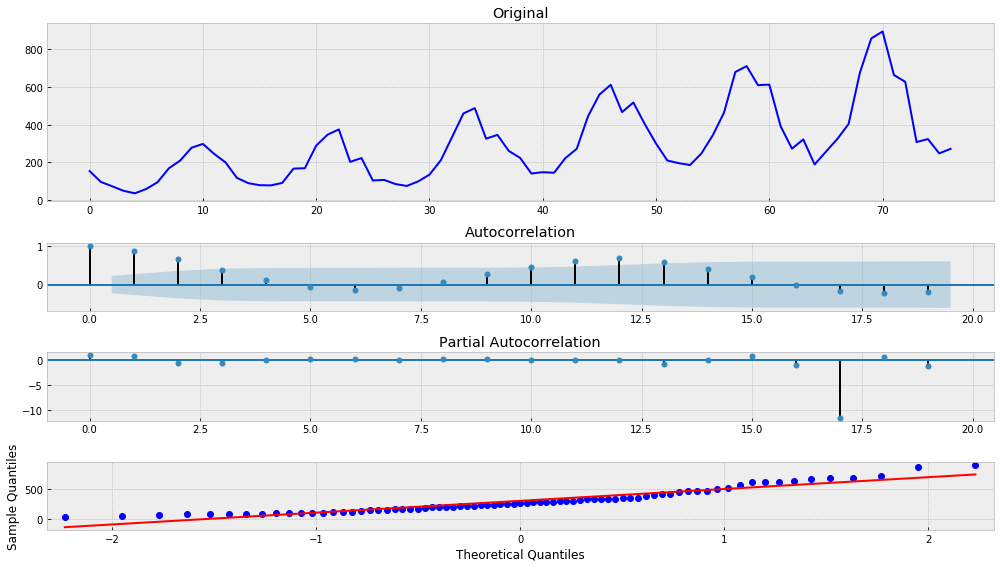

In [28]:
series = sales_of_company_x["Count"]
tsplot(series)

In [13]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 858.17298 | order: (3, 1, 2)


Results of Dickey-Fuller Test:
Test Statistic                 -2.024895
p-value                         0.275765
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


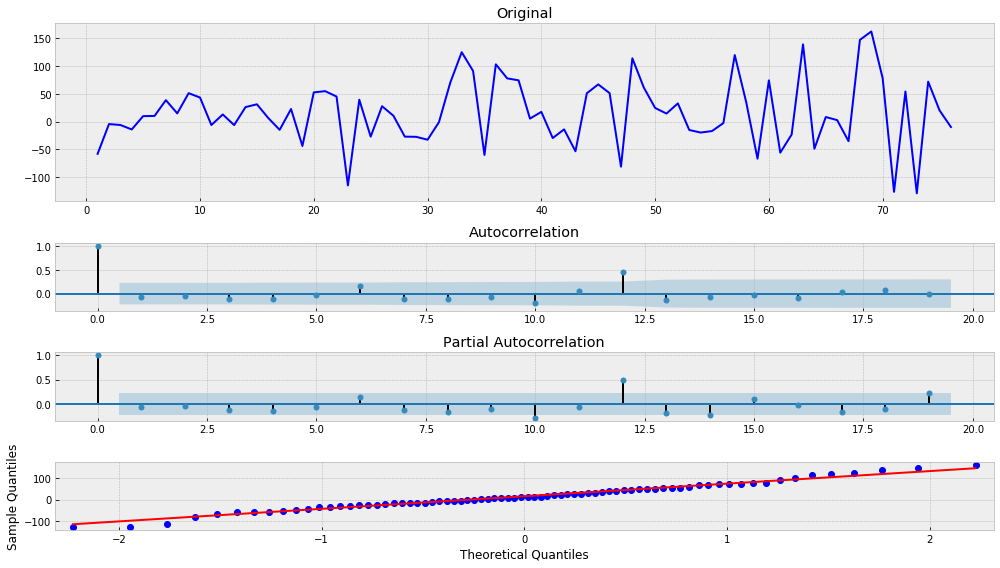

In [14]:
tsplot(mdl.resid)

Results of Dickey-Fuller Test:
Test Statistic                 -2.385128
p-value                         0.145978
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


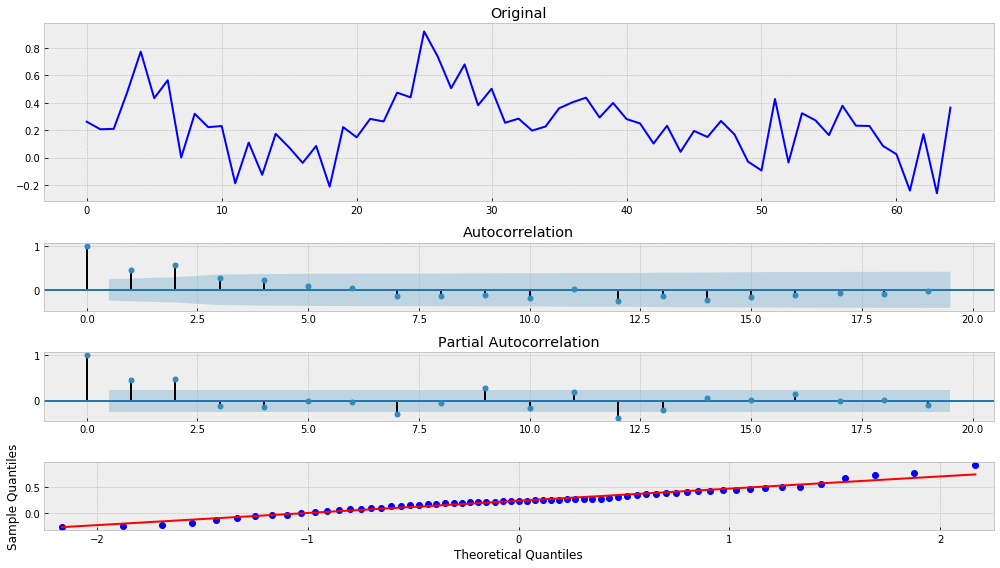

In [29]:
series = boxcox(series, 0)
series = series[12:] - series[:-12]
tsplot(series)

#series = series[12:] - series[:-12]
#series = series[1:] - series[:-1]

In [21]:
#series = series.astype(float)

In [30]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 3
o_ = 1
q_ = 2

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:                5.07208
Distribution:      Standardized Student's t   AIC:                           7.85583
Method:                  Maximum Likelihood   BIC:                           27.4253
                                              No. Observations:                   65
Date:                      Sat, Jan 30 2021   Df Residuals:                       56
Time:                              12:01:36   Df Model:                            9
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0536. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Results of Dickey-Fuller Test:
Test Statistic                 -2.385128
p-value                         0.145978
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


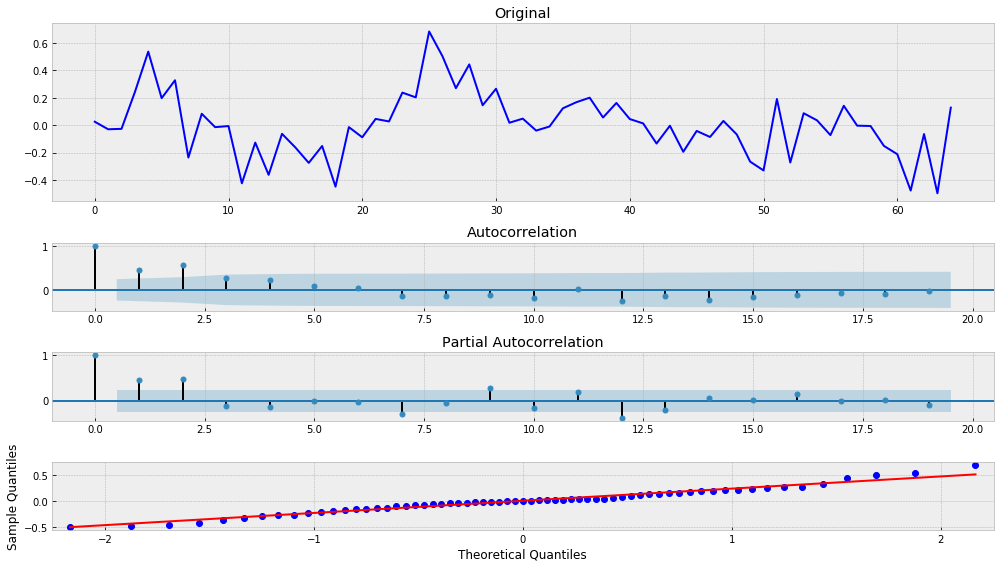

In [31]:
tsplot(res.resid)